In [1]:
import wandb
wandb.login(key="93b4881869bab13360839595daa56e51dd0405df")
#93b4881869bab13360839595daa56e51dd0405df

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shivam-da24m018 (shivam-da24m018-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from PIL import Image
# Vision related imports
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Utility imports
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report

# W&B integration
import wandb

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Set device for computation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def prepare_datasets(root_path, image_size=299, batch_size=32):
    """
    Prepare and load datasets with necessary transformations
    
    Args:
        root_path: Path to dataset root directory
        image_size: Size to resize images to (299x299 for InceptionV3)
        batch_size: Mini-batch size
        
    Returns:
        Three data loaders for training, validation, and testing
    """
    # Define image transformations with proper normalization for InceptionV3
    transform_pipeline = Compose([
        Resize((image_size, image_size)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load training and validation datasets with transformations
    train_dataset = datasets.ImageFolder(
        os.path.join(root_path, 'train'),
        transform=transform_pipeline
    )
    val_dataset = datasets.ImageFolder(
        os.path.join(root_path, 'val'),
        transform=transform_pipeline
    )
    # Extract class labels
    labels = train_dataset.classes
    # Partition dataset into training and validation subsets
    train_data, val_data = random_split(
        train_dataset,
        [8000, 1999],
        generator=torch.Generator().manual_seed(42)
    )
    # Define DataLoader for training with 'spawn' multiprocessing context
    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        multiprocessing_context='spawn'  # Add this line
    )
    
    val_loader = DataLoader(
        val_data, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        multiprocessing_context='spawn'  # Add this line
    )
    
    test_loader = DataLoader(
        val_dataset,
        batch_size=batch_size, 
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        multiprocessing_context='spawn'  # Add this line
    )
    
    return train_loader, val_loader, test_loader, labels

def configure_layer_training(network, freeze_method, num_layers=1):
    """
    Configure which layers of the network should be frozen during training
    
    Args:
        network: The neural network model
        freeze_method: Which layers to freeze ('all', 'allconv', 'allfc', 'first', 'last', 'No')
        num_layers: Number of layers to freeze (only used for 'first' and 'last' strategies)
        
    Returns:
        Modified network with frozen layers
    """
    # Log the freeze strategy to W&B
    wandb.log({"freeze_strategy": freeze_method, "frozen_layer_count": num_layers})
    
    # Get total layer count for reference
    total_layer_count = len(list(network.named_children()))
    
    # Check if num_layers is valid for 'first' and 'last' strategies
    if freeze_method in ['first', 'last'] and (num_layers < 0 or num_layers >= total_layer_count):
        raise ValueError(f"Number of layers to freeze must be between 0 and {total_layer_count-1}")
    
    if freeze_method == "No":
        wandb.log({"trainable_params": sum(p.numel() for p in network.parameters() if p.requires_grad)})
        print("Training all network parameters (no frozen layers)")
        return network
        
    elif freeze_method == "all":
        # Freeze all layers except the last layer (fc layer)
        for name, component in network.named_children():
            if name != 'fc':  # Skip the final fully connected layer
                for param in component.parameters():
                    param.requires_grad = False
        print("Freezing all layers except the final classification layer")
            
    elif freeze_method == "allconv":
        # Freeze all convolutional layers
        for name, component in network.named_children():
            # Check if the module contains convolutional layers
            contains_conv = any(isinstance(m, nn.Conv2d) for m in component.modules())
            if contains_conv:
                for param in component.parameters():
                    param.requires_grad = False
        print("Freezing all convolutional layers, training others")
            
    elif freeze_method == "allfc":
        # Freeze all fully connected layers except the last one
        for name, component in network.named_children():
            # Check if the module is or contains fully connected layers 
            # but is not the final fc layer
            if name != 'fc' and any(isinstance(m, nn.Linear) for m in component.modules()):
                for param in component.parameters():
                    param.requires_grad = False
        print("Freezing all fully connected layers except the final classification layer")
            
    elif freeze_method == "first":
        # Freeze first k layers
        counter = 0
        for name, component in network.named_children():
            counter += 1
            if counter <= num_layers:
                for param in component.parameters():
                    param.requires_grad = False
        print(f"Freezing first {num_layers} layers, training all others")
                    
    elif freeze_method == "last":
        # Freeze last k layers except the final fc layer
        freeze_start = total_layer_count - num_layers
        counter = 0
        for name, component in network.named_children():
            counter += 1
            if counter > freeze_start and name != 'fc':
                for param in component.parameters():
                    param.requires_grad = False
        print(f"Freezing last {num_layers} layers (except final classification layer), training all others")
    
    # Log number of trainable parameters
    trainable_params = sum(p.numel() for p in network.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in network.parameters())
    wandb.log({
        "trainable_params": trainable_params,
        "total_params": total_params,
        "trainable_percentage": (trainable_params/total_params)*100
    })
                    
    return network

def create_optimizer(optimizer_name, model_params, config):
    """
    Create and configure optimizer based on provided name and parameters
    
    Args:
        optimizer_name: Name of the optimizer to use
        model_params: Model parameters to optimize
        config: Dictionary containing optimizer configuration
        
    Returns:
        Configured optimizer instance
    """
    opt_name = optimizer_name.lower()
    
    if opt_name == 'sgd':
        return optim.SGD(
            model_params, 
            lr=config['learning_rate'], 
            momentum=config['momentum'],
            weight_decay=config.get('weight_decay', 0)
        )
    elif opt_name == 'adam':
        return optim.Adam(
            model_params, 
            lr=config['learning_rate'], 
            betas=(0.9, 0.999), 
            eps=1e-8,
            weight_decay=config.get('weight_decay', 0)
        )
    elif opt_name == 'rmsprop':
        return optim.RMSprop(
            model_params, 
            lr=config['learning_rate'], 
            alpha=0.99, 
            eps=1e-8,
            weight_decay=config.get('weight_decay', 0)
        )
    elif opt_name == 'adagrad':
        return optim.Adagrad(
            model_params, 
            lr=config['learning_rate'], 
            lr_decay=0, 
            weight_decay=config.get('weight_decay', 0), 
            initial_accumulator_value=0, 
            eps=1e-10
        )
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

def plot_confusion_matrix(y_true, y_pred, class_names, save_path=None, phase="validation"):
    """
    Create and plot a confusion matrix using matplotlib and seaborn
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        class_names: List of class names
        save_path: Optional path to save the figure
        phase: Which phase this confusion matrix represents (training, validation, test)
    """
    # Convert labels to class indices if they aren't already
    if isinstance(y_true[0], torch.Tensor):
        y_true = [y.item() for y in y_true]
    if isinstance(y_pred[0], torch.Tensor):
        y_pred = [y.item() for y in y_pred]
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure and axis
    plt.figure(figsize=(12, 10))
    
    # Plot confusion matrix as a heatmap
    sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues", 
        xticklabels=class_names,
        yticklabels=class_names
    )
    
    # Set labels and title
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {phase.capitalize()} Phase')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    
    # Save figure if a path is provided
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to {save_path}")
    
    # Display the figure
    plt.show()
    
    # Log to W&B as well
    wandb.log({f"confusion_matrix_{phase}": wandb.Image(plt)})
    
    # Close the figure to free memory
    plt.close()
    
    # Also log the classification report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    # Convert the report to a format that can be logged to W&B
    for cls in report:
        if cls not in ['accuracy', 'macro avg', 'weighted avg']:
            wandb.log({
                f"{phase}_precision_{cls}": report[cls]['precision'],
                f"{phase}_recall_{cls}": report[cls]['recall'],
                f"{phase}_f1_{cls}": report[cls]['f1-score'],
                f"{phase}_support_{cls}": report[cls]['support']
            })
    
    # Log overall metrics
    wandb.log({
        f"{phase}_macro_precision": report['macro avg']['precision'],
        f"{phase}_macro_recall": report['macro avg']['recall'],
        f"{phase}_macro_f1": report['macro avg']['f1-score'],
        f"{phase}_accuracy": report['accuracy']
    })
    
    return cm

def log_wandb_confusion_matrix(y_true, y_pred, class_names):
    """
    Create and log confusion matrix to W&B
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        class_names: List of class names
    """
    # Create confusion matrix
    cm = wandb.plot.confusion_matrix(
        y_true=y_true,
        preds=y_pred,
        class_names=class_names
    )
    wandb.log({"confusion_matrix": cm})

def visualize_model_predictions(model, dataset, class_names, num_samples=16, save_path=None):
    """
    Visualize model predictions on random images using matplotlib
    
    Args:
        model: Trained model
        dataset: Dataset to sample from
        class_names: List of class names
        num_samples: Number of samples to visualize
        save_path: Optional path to save the figure
    """
    # Switch model to evaluation mode
    model.eval()
    
    # Sample images
    samples_idx = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    samples = [dataset[i] for i in samples_idx]
    
    # Calculate grid dimensions
    grid_size = int(np.ceil(np.sqrt(num_samples)))
    
    # Create figure
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.flatten()
    
    for i, (img_tensor, label) in enumerate(samples):
        if i >= num_samples:
            break
            
        img_tensor = img_tensor.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(img_tensor)
            _, predicted = torch.max(output, 1)
            probabilities = F.softmax(output, dim=1)
            confidence = probabilities[0][predicted.item()].item()
        
        # Convert image tensor to numpy array for visualization
        img_np = img_tensor.cpu().squeeze().permute(1, 2, 0).numpy()
        img_np = np.clip((img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])), 0, 1)
        
        # Display image
        axes[i].imshow(img_np)
        
        # Set title with prediction and confidence
        title_color = 'green' if predicted.item() == label else 'red'
        axes[i].set_title(
            f"True: {class_names[label]}\nPred: {class_names[predicted.item()]}\nConf: {confidence:.2f}",
            color=title_color
        )
        axes[i].axis('off')
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path)
        print(f"Prediction visualization saved to {save_path}")
    
    # Display figure
    plt.show()
    
    # Log to W&B
    wandb.log({"model_predictions": wandb.Image(fig)})
    
    # Close figure to free memory
    plt.close(fig)

def log_model_predictions(model, dataset, class_names, num_samples=30):
    """
    Log model predictions on random images to W&B
    
    Args:
        model: Trained model
        dataset: Dataset to sample from
        class_names: List of class names
        num_samples: Number of samples to log
    """
    # Switch model to evaluation mode
    model.eval()
    
    # Sample images
    samples_idx = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    samples = [dataset[i] for i in samples_idx]
    
    images = []
    captions = []
    
    for img_tensor, label in samples:
        img_tensor = img_tensor.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(img_tensor)
            _, predicted = torch.max(output, 1)
            probabilities = F.softmax(output, dim=1)
            confidence = probabilities[0][predicted.item()].item()
        
        # Convert image tensor to a format W&B can use
        img_np = img_tensor.cpu().squeeze().permute(1, 2, 0).numpy()
        img_np = np.clip((img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255, 0, 255).astype(np.uint8)
        
        # Create caption
        caption = f"True: {class_names[label]}\nPred: {class_names[predicted.item()]}\nConf: {confidence:.2f}"
        
        images.append(img_np)
        captions.append(caption)
    
    # Log images with predictions to W&B
    wandb.log({"predictions": [wandb.Image(img, caption=cap) for img, cap in zip(images, captions)]})

def plot_training_history(history, save_path=None):
    """
    Plot training and validation metrics history
    
    Args:
        history: Dictionary containing training history
        save_path: Optional path to save the figure
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history['train_accuracy'], label='Training Accuracy')
    ax2.plot(history['val_accuracy'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path)
        print(f"Training history plot saved to {save_path}")
    
    # Display figure
    plt.show()
    
    # Log to W&B
    wandb.log({"training_history": wandb.Image(fig)})
    
    # Close figure to free memory
    plt.close(fig)

def train_and_evaluate(config, freeze_layer_count=0, freeze_strategy="No"):
    """
    Train and evaluate a model with specified configuration
    
    Args:
        config: Dictionary with training configuration
        freeze_layer_count: Number of layers to freeze
        freeze_strategy: Strategy for freezing layers
        
    Returns:
        Trained model and test accuracy
    """
    # Create output directory for visualizations
    output_dir = f"output_{freeze_strategy}"
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize W&B run
    with wandb.init(
        project=config['project_name'],
        name=f"{config['run_name']}_{freeze_strategy}",
        config=config
    ):
        # Log configuration to W&B
        wandb.config.update({
            "freeze_strategy": freeze_strategy,
            "frozen_layers": freeze_layer_count,
            "model": "InceptionV3"
        })
        
        # Load datasets
        train_loader, val_loader, test_loader, labels = prepare_datasets(
            config['data_path'], 
            image_size=299,  # InceptionV3 expects 299x299 input
            batch_size=config['batch_size']
        )
        
        # Initialize model with pretrained weights
        net = torchvision.models.inception_v3(pretrained=True)
        
        # Modify final classification layer
        # InceptionV3 has two outputs, main output and aux output
        num_classes = len(labels)
        net.fc = nn.Linear(net.fc.in_features, num_classes)
        net.AuxLogits.fc = nn.Linear(net.AuxLogits.fc.in_features, num_classes)
        
        # Apply freezing strategy
        net = configure_layer_training(
            net, 
            freeze_strategy,
            freeze_layer_count
        )
        
        # Move model to device
        net = net.to(device)
        
        # Set up loss function
        criterion = nn.CrossEntropyLoss()
        
        # Set up optimizer
        optimizer = create_optimizer(config['optimizer'], 
                                    filter(lambda p: p.requires_grad, net.parameters()), 
                                    config)
        
        # Set up learning rate scheduler if specified
        scheduler = None
        if config.get('use_scheduler', False):
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, 
                mode='min', 
                factor=0.1, 
                patience=2, 
                verbose=True
            )
            
        # Initialize tracking of best model
        best_val_accuracy = 0.0
        best_model_state = None
        
        # For tracking history
        history = {
            'train_loss': [],
            'train_accuracy': [],
            'val_loss': [],
            'val_accuracy': []
        }
        
        # Training loop
        for epoch in range(config['epochs']):
            # Training phase
            net.train()
            running_loss = 0.0
            correct_count = 0
            total_samples = 0
            
            # Create progress bar for training
            train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Train]")
            
            # Process training batches
            for inputs, targets in train_progress:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Zero gradients
                optimizer.zero_grad()
                
                # Forward pass - InceptionV3 returns (output, aux_output) during training
                outputs = net(inputs)
                
                # Handle both outputs if in training mode
                if isinstance(outputs, tuple):
                    main_output, aux_output = outputs
                    # Calculate combined loss with auxiliary classifier
                    loss = criterion(main_output, targets) + 0.3 * criterion(aux_output, targets)
                    outputs = main_output
                else:
                    loss = criterion(outputs, targets)
                
                # Backward pass
                loss.backward()
                
                # Update weights
                optimizer.step()
                
                # Update statistics
                running_loss += loss.item()
                _, predictions = torch.max(outputs.data, 1)
                total_samples += targets.size(0)
                correct_count += (predictions == targets).sum().item()
                
                # Update progress bar
                train_progress.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{(predictions == targets).sum().item() / targets.size(0):.4f}"
                })
            
            # Calculate training metrics
            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy = (correct_count / total_samples) * 100
            
            # Store history
            history['train_loss'].append(epoch_loss)
            history['train_accuracy'].append(epoch_accuracy)
            
            # Log training metrics to W&B
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": epoch_loss,
                "train_accuracy": epoch_accuracy,
                "learning_rate": optimizer.param_groups[0]['lr']
            })
            
            # Validation phase
            net.eval()
            val_running_loss = 0.0
            val_correct_count = 0
            val_total_samples = 0
            
            # For confusion matrix
            all_targets = []
            all_predictions = []
            
            # Create progress bar for validation
            val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['epochs']} [Valid]")
            
            with torch.no_grad():
                for val_inputs, val_targets in val_progress:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                    
                    # Forward pass
                    val_outputs = net(val_inputs)
                    
                    # Calculate loss
                    val_loss = criterion(val_outputs, val_targets)
                    
                    # Update statistics
                    val_running_loss += val_loss.item()
                    _, val_predictions = torch.max(val_outputs.data, 1)
                    val_total_samples += val_targets.size(0)
                    val_correct_count += (val_predictions == val_targets).sum().item()
                    
                    # Collect targets and predictions for confusion matrix
                    all_targets.extend(val_targets.cpu().numpy())
                    all_predictions.extend(val_predictions.cpu().numpy())
                    
                    # Update progress bar
                    val_progress.set_postfix({
                        'loss': f"{val_loss.item():.4f}",
                        'acc': f"{(val_predictions == val_targets).sum().item() / val_targets.size(0):.4f}"
                    })
            
            # Calculate validation metrics
            val_epoch_loss = val_running_loss / len(val_loader)
            val_epoch_accuracy = (val_correct_count / val_total_samples) * 100
            
            # Store history
            history['val_loss'].append(val_epoch_loss)
            history['val_accuracy'].append(val_epoch_accuracy)
            
            # Log validation metrics to W&B
            wandb.log({
                "val_loss": val_epoch_loss,
                "val_accuracy": val_epoch_accuracy
            })
            
            # Update learning rate if scheduler is used
            if scheduler:
                scheduler.step(val_epoch_loss)
            
            # Save best model
            if val_epoch_accuracy > best_val_accuracy:
                best_val_accuracy = val_epoch_accuracy
                best_model_state = net.state_dict()
                
                # Save model checkpoint
                checkpoint_path = os.path.join(output_dir, f"best_model_epoch_{epoch+1}.pth")
                torch.save(net.state_dict(), checkpoint_path)
                wandb.save(checkpoint_path)
            
            
            # Print epoch results
            print(f"Epoch {epoch+1}/{config['epochs']}:")
            print(f"  Train - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
            print(f"  Valid - Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.2f}%")
        
        # Plot training history
        history_path = os.path.join(output_dir, "training_history.png")
        plot_training_history(history, history_path)
        
        # Load best model for testing
        if best_model_state:
            net.load_state_dict(best_model_state)
        
        # Test phase
        net.eval()
        test_running_loss = 0.0
        test_correct_count = 0
        test_total_samples = 0
        
        # For final confusion matrix
        test_targets = []
        test_predictions = []
        
        # Create progress bar for testing
        test_progress = tqdm(test_loader, desc="Testing")
        
        with torch.no_grad():
            for test_inputs, test_targets_batch in test_progress:
                test_inputs, test_targets_batch = test_inputs.to(device), test_targets_batch.to(device)
                
                # Forward pass
                test_outputs = net(test_inputs)
                
                # Calculate loss
                test_loss = criterion(test_outputs, test_targets_batch)
                
                # Update statistics
                test_running_loss += test_loss.item()
                _, test_predictions_batch = torch.max(test_outputs.data, 1)
                test_total_samples += test_targets_batch.size(0)
                test_correct_count += (test_predictions_batch == test_targets_batch).sum().item()
                
                # Collect targets and predictions for confusion matrix
                test_targets.extend(test_targets_batch.cpu().numpy())
                test_predictions.extend(test_predictions_batch.cpu().numpy())
                
                # Update progress bar
                test_progress.set_postfix({
                    'loss': f"{test_loss.item():.4f}",
                    'acc': f"{(test_predictions_batch == test_targets_batch).sum().item() / test_targets_batch.size(0):.4f}"
                })
        
        # Calculate test metrics
        test_epoch_loss = test_running_loss / len(test_loader)
        test_epoch_accuracy = (test_correct_count / test_total_samples) * 100
        
        # Log test metrics to W&B
        wandb.log({
            "test_loss": test_epoch_loss,
            "test_accuracy": test_epoch_accuracy
        })
        
        # Log final confusion matrix - both to W&B and locally
        log_wandb_confusion_matrix(test_targets, test_predictions, labels)
        cm_test_path = os.path.join(output_dir, "confusion_matrix_test.png")
        plot_confusion_matrix(test_targets, test_predictions, labels, cm_test_path, "test")
        
        # Log model predictions - both to W&B and locally
        log_model_predictions(net, test_loader.dataset, labels)
        pred_test_path = os.path.join(output_dir, "predictions_test.png")
        visualize_model_predictions(net, test_loader.dataset, labels, 25, pred_test_path)
        
        # Save final model
        final_model_path = os.path.join(output_dir, "final_model.pth")
        torch.save(net.state_dict(), final_model_path)
        wandb.save(final_model_path)
        
        # Print test results
        print(f"Test Results - Loss: {test_epoch_loss:.4f}, Accuracy: {test_epoch_accuracy:.2f}%")
        
        return net, test_epoch_accuracy



Using device: cuda:0


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.



Running Experiment: AllConv_Frozen


wandb: Tracking run with wandb version 0.19.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250418_171726-17x44rwr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run InceptionV3_AllConv_Frozen_allconv
wandb: ⭐️ View project at https://wandb.ai/shivam-da24m018-iitmaana/DA6401_Assignment2_PartB
wandb: 🚀 View run at https://wandb.ai/shivam-da24m018-iitmaana/DA6401_Assignment2_PartB/runs/17x44rwr
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAU

Freezing all convolutional layers, training others


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10 [Train]:   0%|          | 0/250 [00:10<?, ?it/s]

Epoch 1/10 [Valid]:   0%|          | 0/63 [00:10<?, ?it/s]

Epoch 1/10:
  Train - Loss: 2.0630, Accuracy: 60.49%
  Valid - Loss: 0.9358, Accuracy: 71.84%


Epoch 2/10 [Train]:   0%|          | 0/250 [00:10<?, ?it/s]

Epoch 2/10 [Valid]:   0%|          | 0/63 [00:10<?, ?it/s]

Epoch 2/10:
  Train - Loss: 1.7018, Accuracy: 69.76%
  Valid - Loss: 0.8238, Accuracy: 74.74%


Epoch 3/10 [Train]:   0%|          | 0/250 [00:10<?, ?it/s]

Epoch 3/10 [Valid]:   0%|          | 0/63 [00:10<?, ?it/s]

Epoch 3/10:
  Train - Loss: 1.6457, Accuracy: 71.30%
  Valid - Loss: 0.8259, Accuracy: 73.14%


Epoch 4/10 [Train]:   0%|          | 0/250 [00:10<?, ?it/s]

Epoch 4/10 [Valid]:   0%|          | 0/63 [00:10<?, ?it/s]

Epoch 4/10:
  Train - Loss: 1.6117, Accuracy: 72.16%
  Valid - Loss: 0.8049, Accuracy: 74.74%


Epoch 5/10 [Train]:   0%|          | 0/250 [00:10<?, ?it/s]

Epoch 5/10 [Valid]:   0%|          | 0/63 [00:10<?, ?it/s]

Epoch 5/10:
  Train - Loss: 1.6166, Accuracy: 72.12%
  Valid - Loss: 0.7992, Accuracy: 75.04%


Epoch 6/10 [Train]:   0%|          | 0/250 [00:10<?, ?it/s]

Epoch 6/10 [Valid]:   0%|          | 0/63 [00:10<?, ?it/s]

Epoch 6/10:
  Train - Loss: 1.5966, Accuracy: 72.39%
  Valid - Loss: 0.7891, Accuracy: 74.84%


Epoch 7/10 [Train]:   0%|          | 0/250 [00:10<?, ?it/s]

Epoch 7/10 [Valid]:   0%|          | 0/63 [00:10<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Epoch 7/10:
  Train - Loss: 1.5747, Accuracy: 73.31%
  Valid - Loss: 0.7909, Accuracy: 75.14%


Epoch 8/10 [Train]:   0%|          | 0/250 [00:10<?, ?it/s]

Epoch 8/10 [Valid]:   0%|          | 0/63 [00:10<?, ?it/s]

Epoch 8/10:
  Train - Loss: 1.5777, Accuracy: 72.76%
  Valid - Loss: 0.7954, Accuracy: 74.24%


Epoch 9/10 [Train]:   0%|          | 0/250 [00:10<?, ?it/s]

Epoch 9/10 [Valid]:   0%|          | 0/63 [00:10<?, ?it/s]

Epoch 9/10:
  Train - Loss: 1.5877, Accuracy: 72.71%
  Valid - Loss: 0.7832, Accuracy: 74.99%


Epoch 10/10 [Train]:   0%|          | 0/250 [00:10<?, ?it/s]

Epoch 10/10 [Valid]:   0%|          | 0/63 [00:10<?, ?it/s]

Epoch 10/10:
  Train - Loss: 1.5886, Accuracy: 72.65%
  Valid - Loss: 0.8015, Accuracy: 74.69%
Training history plot saved to output_allconv/training_history.png


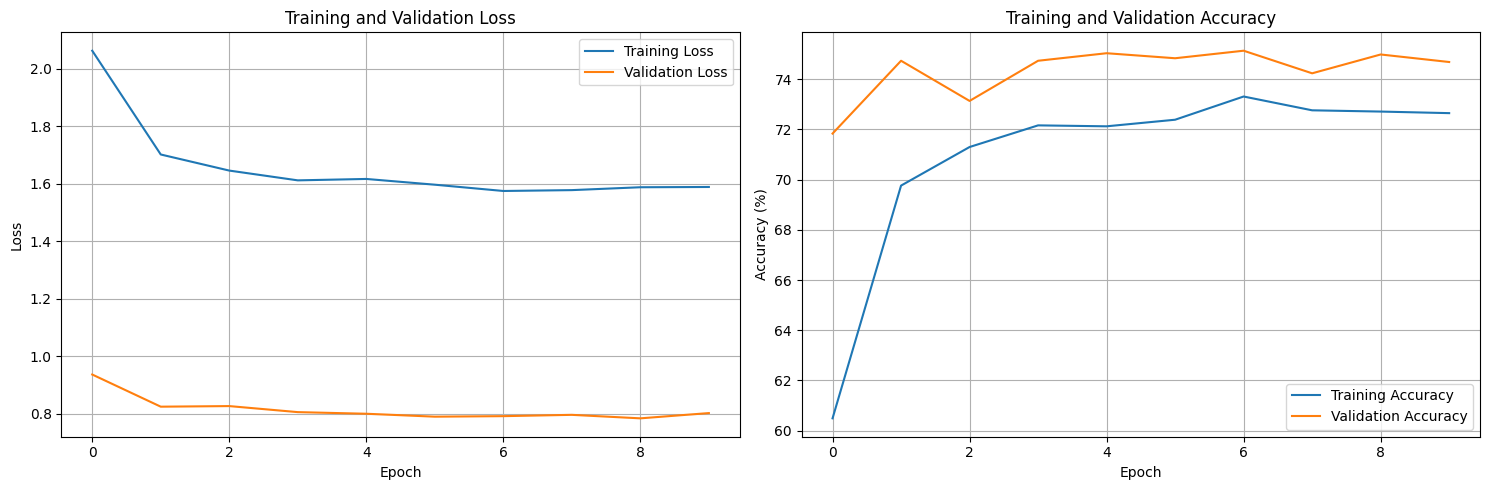

Testing:   0%|          | 0/63 [00:10<?, ?it/s]

Confusion matrix saved to output_allconv/confusion_matrix_test.png


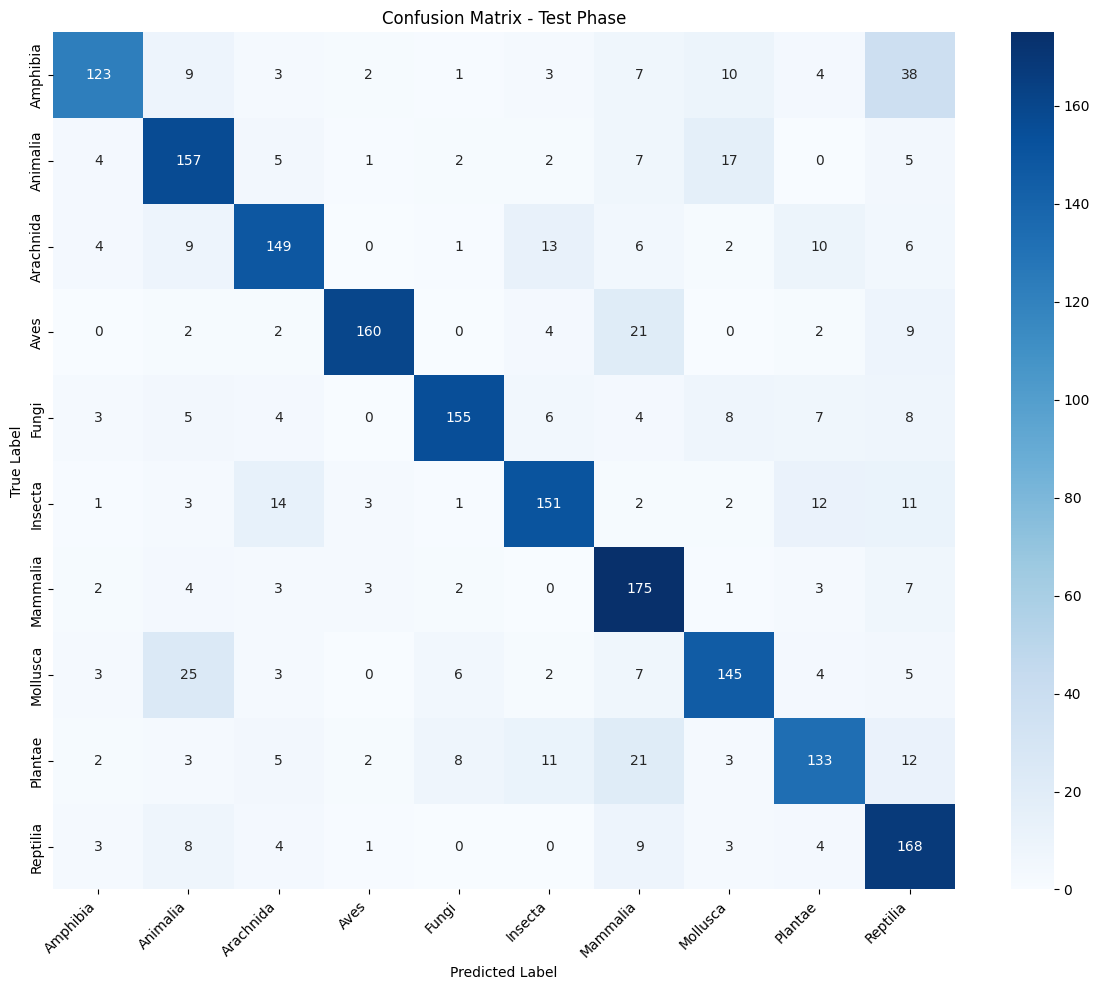

Prediction visualization saved to output_allconv/predictions_test.png


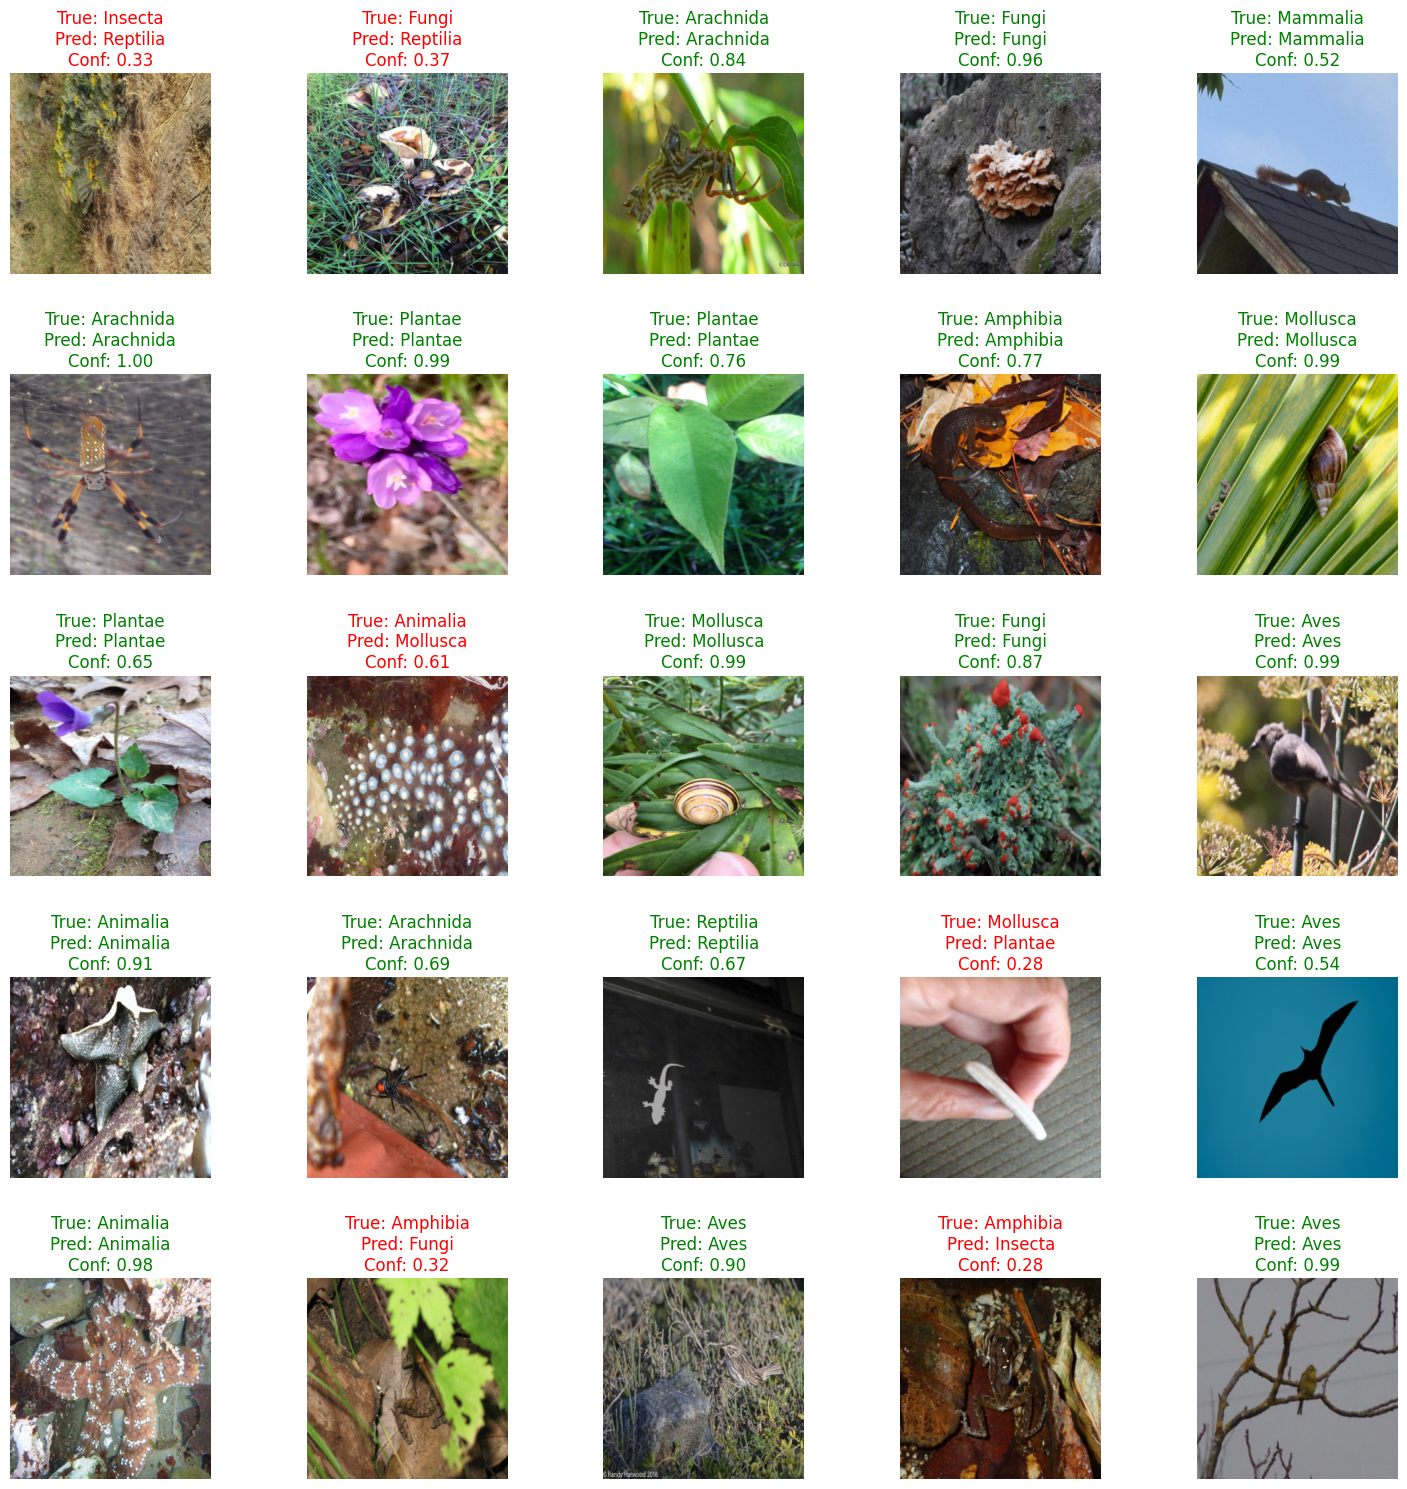

Test Results - Loss: 0.7466, Accuracy: 75.80%


wandb: uploading media/images/model_predictions_38_6ceb036c4c1a773a40bf.png; uploading output_allconv/final_model.pth; uploading output.log; uploading wandb-summary.json; uploading config.yaml (+ 4 more)
wandb: uploading media/images/model_predictions_38_6ceb036c4c1a773a40bf.png; uploading output_allconv/final_model.pth; uploading output_allconv/best_model_epoch_1.pth; uploading output_allconv/best_model_epoch_2.pth; uploading output_allconv/best_model_epoch_5.pth (+ 1 more)
wandb: uploading output_allconv/final_model.pth; uploading output_allconv/best_model_epoch_1.pth; uploading output_allconv/best_model_epoch_2.pth; uploading output_allconv/best_model_epoch_5.pth; uploading output_allconv/best_model_epoch_7.pth
wandb: uploading output_allconv/final_model.pth
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                    epoch ▁▂▃▃▄▅▆▆▇█
wandb:       frozen_layer_count ▁
wandb:            learning_rate ▁▁▁▁

{'AllConv_Frozen': 75.8}


In [3]:
def run_experiments(base_config):
    """
    Run a series of experiments with different freezing strategies
    
    Args:
        base_config: Base configuration for all experiments
        
    Returns:
        Dictionary of results
    """
    results = {}
    
    # List of experiments to run
    experiments = [        
        {"name": "AllConv_Frozen", "strategy": "allconv", "layers": 0},
     
    ]
    
    for exp in experiments:
        print(f"\n{'='*50}")
        print(f"Running Experiment: {exp['name']}")
        print(f"{'='*50}")
        
        # Update run name for this experiment
        config = base_config.copy()
        config['run_name'] = f"{base_config['run_name']}_{exp['name']}"
        
        # Run experiment
        _, accuracy = train_and_evaluate(
            config, 
            freeze_layer_count=exp['layers'], 
            freeze_strategy=exp['strategy']
        )
        
        # Store result
        results[exp['name']] = accuracy
    
    # Plot comparative results
    
    
    return results



def visualize_feature_maps(model, data_loader, save_dir="feature_maps"):
    """
    Visualize feature maps from convolutional layers
    
    Args:
        model: Trained model
        data_loader: DataLoader containing samples to visualize
        save_dir: Directory to save feature maps
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Set model to evaluation mode
    model.eval()
    
    # Get a sample batch
    images, labels = next(iter(data_loader))
    
    # Select a sample image
    sample_image = images[0].unsqueeze(0).to(device)
    
    # List to store outputs
    feature_maps = []
    
    # Create hooks for convolutional layers
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    
    # Register hooks for convolutional layers in the model
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            module.register_forward_hook(get_activation(name))
    
    # Forward pass
    with torch.no_grad():
        outputs = model(sample_image)
    
    # Plot and save feature maps
    for layer_name, feature_map in activation.items():
        # Only process first image in batch
        feature_map = feature_map[0]
        
        # Get number of channels
        num_channels = feature_map.size(0)
        
        # Select up to 64 channels to visualize
        channels_to_plot = min(64, num_channels)
        
        # Calculate grid size
        grid_size = int(np.ceil(np.sqrt(channels_to_plot)))
        
        # Create figure
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
        axes = axes.flatten()
        
        # Plot each channel
        for i in range(channels_to_plot):
            # Extract channel and convert to numpy
            channel = feature_map[i].cpu().numpy()
            
            # Normalize channel for better visualization
            channel = (channel - channel.min()) / (channel.max() - channel.min() + 1e-8)
            
            # Plot channel
            axes[i].imshow(channel, cmap='viridis')
            axes[i].axis('off')
        
        # Hide unused subplots
        for j in range(channels_to_plot, len(axes)):
            axes[j].axis('off')
        
        # Set title and adjust layout
        plt.suptitle(f"Feature Maps: {layer_name}", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        
        # Save figure
        save_path = os.path.join(save_dir, f"feature_map_{layer_name.replace('.', '_')}.png")
        plt.savefig(save_path)
        
        # Log to W&B
        wandb.log({f"feature_map_{layer_name}": wandb.Image(fig)})
        
        # Close figure to free memory
        plt.close(fig)
    
    print(f"Feature maps saved to {save_dir}")

def evaluate_model_on_classes(model, test_loader, class_names):
    """
    Evaluate model performance on each class
    
    Args:
        model: Trained model
        test_loader: DataLoader for test set
        class_names: List of class names
    """
    # Set model to evaluation mode
    model.eval()
    
    # Initialize per-class metrics
    num_classes = len(class_names)
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    # For storing all predictions and targets
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating per-class metrics"):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Get predictions
            _, predicted = torch.max(outputs, 1)
            
            # Update per-class metrics
            for i in range(labels.size(0)):
                label = labels[i]
                prediction = predicted[i]
                class_total[label] += 1
                if label == prediction:
                    class_correct[label] += 1
            
            # Collect all predictions and targets
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    # Calculate per-class accuracy
    class_accuracy = [100 * correct / total for correct, total in zip(class_correct, class_total)]
    
    # Create DataFrame for better visualization
    df = pd.DataFrame({
        'Class': class_names,
        'Accuracy (%)': class_accuracy,
        'Correct': class_correct,
        'Total': class_total
    })
    
    # Sort by accuracy
    df = df.sort_values('Accuracy (%)', ascending=False)
    
    # Create bar plot
    plt.figure(figsize=(15, 8))
    bars = plt.bar(df['Class'], df['Accuracy (%)'], color='skyblue', edgecolor='black')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # Set labels and title
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-Class Accuracy')
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('per_class_accuracy.png')
    
    # Show the plot
    plt.show()
    
    # Log to W&B
    wandb.log({"per_class_accuracy": wandb.Image(plt)})
    
    # Close figure to free memory
    plt.close()
    
    # Generate classification report
    report = classification_report(all_targets, all_predictions, target_names=class_names)
    print("\nClassification Report:")
    print(report)
    
    # Return the per-class accuracy
    return class_accuracy

if __name__ == "__main__":
    # Dataset location and parameters
    data_location = '/kaggle/input/da6401-2/inaturalist_12K'
    
    # Configuration for experiments
    base_config = {
        'project_name': 'DA6401_Assignment2_PartB',
        'run_name': 'InceptionV3',
        'optimizer': 'adam',
        'learning_rate': 0.001,
        'momentum': 0.9,
        'weight_decay': 1e-4,
        'epochs': 10,
        'batch_size': 32,
        'data_path': data_location,
        'use_scheduler': True
    }
    
    results = run_experiments(base_config)
    print(results)